## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

### Q1.

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents.

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [ ]:
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
df = pd.read_parquet('/Phishing_Email.parquet')
tokens = df['Email Text'].str.split()
print(tokens)

0        [re, :, 6, ., 1100, ,, disc, :, uniformitarian...
1        [the, other, side, of, *, galicismos, *, *, ga...
2        [re, :, equistar, deal, tickets, are, you, sti...
3        [Hello, I, am, your, hot, lil, horny, toy., I,...
4        [software, at, incredibly, low, prices, (, 86,...
                               ...                        
18629    [date, a, lonely, housewife, always, wanted, t...
18630    [request, submitted, :, access, request, for, ...
18631    [re, :, important, -, prc, mtg, hi, dorn, &, j...
18632    [press, clippings, -, letter, on, californian,...
18633                                              [empty]
Name: Email Text, Length: 18634, dtype: object


#1
To clean this data, I would remove punctuation/symbols, common words, and numbers. Then, I would one-hot encode these tokens, which means turning them into a format where each token is represented as a binary feature (1 if the token is present in the email, 0 if not). These features would serve as the input for predicting whether the email is a phishing scam. To make the prediction, I’d use algorithms that analyze the presence or absence of these tokens to determine if they indicate a scam.

### Q2.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [6]:
import pickle

with open('/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

,count
count,48691.000000
mean,5.687889
std,27.717476
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,1365.000000


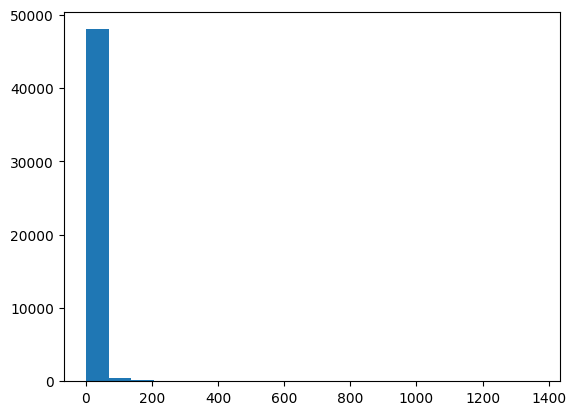

In [10]:
gdf = pd.DataFrame(token_freq,columns=['token','count'])
gdf['count'].hist(grid=False,bins=20)

gdf['count'].describe()

#2
Most tokens occur only once, and only a small number appear more than 10 times. Even at the 75th percentile, tokens show up just twice. However, the most frequent token appears 1,365 times.

### Q3.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import numpy as np

df = pd.read_parquet('/Phishing_clean.parquet')

y = df['Email Type']
X = df.drop(columns=['Email Type'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=125
)

lm_0 = LinearRegression(fit_intercept=False)
lm_0.fit(X_train, y_train)

y_hat_train_0 = lm_0.predict(X_train)
y_hat_test_0 = lm_0.predict(X_test)

train_r2 = r2_score(y_train, y_hat_train_0)
test_r2 = r2_score(y_test, y_hat_test_0)
print(f'Training R^2: {train_r2}')
print(f'Testing R^2: {test_r2}')

rdf = pd.DataFrame({'variable':lm_0.feature_names_in_ , 'value':lm_0.coef_})
rdf['abs'] = np.abs(rdf['value'])
rdf.sort_values('abs',ascending=False)

Training R^2: 0.6948655461957206
Testing R^2: -1.4727860414155143e+22


,variable,value,abs
710,1997,-1.415784e+13,1.415784e+13
421,1995,1.158467e+13,1.158467e+13
1133,"19,",-1.025713e+13,1.025713e+13
340,2005,-9.773947e+12,9.773947e+12
1146,-0400,-8.062341e+12,8.062341e+12
...,...,...,...
1399,union,2.822876e-04,2.822876e-04
565,east,-2.746582e-04,2.746582e-04
2268,ravages,-1.068115e-04,1.068115e-04
457,due,-6.484985e-05,6.484985e-05


#3
The words that have the largest coefficients in absolute value and most strongly influence predictions are numbers like "1997", "1995", "19,", "2005", and "-0400".

### Q4.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

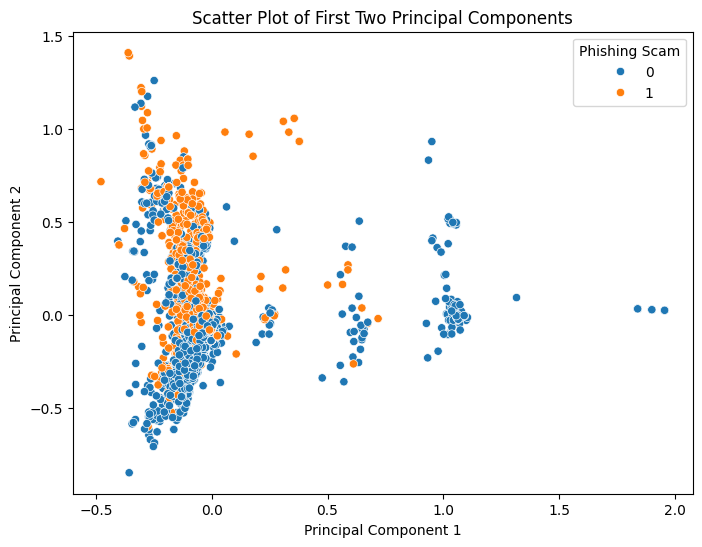

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
Z_train = pca.fit_transform(X_train)
Z_test = pca.transform(X_test)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test)
plt.title('Scatter Plot of First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Phishing Scam', loc='best')
plt.show()

#4
The scatter plot shows that there’s a lot of overlap between phishing emails and non-phishing emails, meaning the two groups are not completely distinct. The first principal component (PC1) seems to separate some phishing emails from the rest, but it’s not very clear-cut. The second principal component (PC2) doesn’t seem to add much useful separation, and there are a few unusual outliers that stand apart from the main clusters.

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [21]:
pca = PCA(n_components=2610)
Z_train = pca.fit_transform(X_train)
Z_test = pca.transform(X_test)

lm_k = LinearRegression()
lm_k.fit(Z_train, y_train)

y_hat_train = lm_k.predict(Z_train)
y_hat_test = lm_k.predict(Z_test)

train_r2 = r2_score(y_train, y_hat_train)
test_r2 = r2_score(y_test, y_hat_test)

print(f'Train R^2: {train_r2}')
print(f'Test R^2: {test_r2}')

Train R^2: 0.7650509639569709
Test R^2: 0.6718439815209292


#5
The performance with PCA is much better than the original linear regression. For the training data, the accuracy improved from 0.69 to 0.77, showing that the model with PCA does a better job of fitting the training data. More importantly, the accuracy on the test data went from a completely meaningless negative number (-1.47e+22) to a much better and positive value (0.67), meaning the PCA model is much better at making predictions on new, unseen emails.

### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

Using principal components reduces the number of features, making the model simpler and less likely to overfit, especially with lots of noisy or redundant data. However, it makes the results harder to interpret since the components are combinations of the original features, and some useful details might get lost in the process.